In [1]:
%matplotlib inline

In [2]:
import sys
sys.executable

'/Users/rdua/opt/anaconda3/bin/python'

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/InceptionV3

In [3]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [6]:
# Output files
model_type='vgg16'
no_of_images = 1000
EPOCHS = 10
_APPEND = '_' + model_type + '_' + str(no_of_images) + '_' + str(EPOCHS)  
APPEND = _APPEND + ".png"

TRAINING_LOGS_FILE = "training_logs" + _APPEND + '.csv'
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "plots/model_plot_" + APPEND
MODEL_FILE = "model/model_vgg16_1000.h5"
TRAINING_PLOT_FILE = "plots/training" +  APPEND
VALIDATION_PLOT_FILE = "plots/validation" + APPEND
ROC_PLOT_FILE = "plots/roc" + APPEND

In [7]:
# Hyperparams
#SAMPLE_COUNT = 85000
#TRAINING_RATIO = 0.9
IMAGE_SIZE = 96 
IMAGE_SIZE2 = 224

BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 100

In [8]:
SAMPLE_COUNT = 200
TRAINING_RATIO = 0.9
TESTING_BATCH_SIZE = 100
BATCH_SIZE = 10

In [23]:
base = '/Users/rdua/work/github/rajdeepd/histopathologic_cancer_detector/'

In [25]:
# Origina data file Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
input_dir = base
training_dir = input_dir + 'training/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame.head()

,path


In [19]:
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split('.')[0])
#data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3])
data_frame.head()

,path,id
0,/Users/rdua/work/github/rajdeepd/histopatholog...,work
1,/Users/rdua/work/github/rajdeepd/histopatholog...,work
2,/Users/rdua/work/github/rajdeepd/histopatholog...,work
3,/Users/rdua/work/github/rajdeepd/histopatholog...,work
4,/Users/rdua/work/github/rajdeepd/histopatholog...,work


In [20]:
labels = pd.read_csv(input_dir + 'train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [21]:
data_frame = data_frame.merge(labels, on='id')
print(data_frame.count(axis=0))
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

path     0
id       0
label    0
dtype: int64


ValueError: a must be greater than 0 unless no samples are taken

In [22]:
data_frame.head()

,path,id,label


In [94]:
training_path = './training1000'
validation_path = './validation1000'


In [95]:
for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        #os.makedirs(path, exist_ok=True)
        print('path exists? ' + path + ":" + str(os.path.exists(path)))
        if not os.path.exists(path):
            print('Creating dirs: ' + path)
            os.makedirs(path)

path exists? ./training1000/0:True
path exists? ./training1000/1:True
path exists? ./validation1000/0:True
path exists? ./validation1000/1:True


In [96]:
training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [97]:
for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    if not os.path.exists(path):
        for image in images['id'].values:
            file_name = image + '.tif'
            label = str(data_frame.loc[image,'label'])
            destination = os.path.join(path, label, file_name)
            print(destination + ': os.path.exists?' + str(os.path.exists(destination)))
            if not os.path.exists(destination):
                source = os.path.join(input_dir + 'train1000', file_name)
                shutil.copyfile(source, destination)
    else:
        print(path + ' already exists')

./training1000 already exists
./validation1000 already exists


In [98]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [99]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE2,
                                                                                           IMAGE_SIZE2),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')
testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

Found 874 images belonging to 2 classes.
Found 185 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [100]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


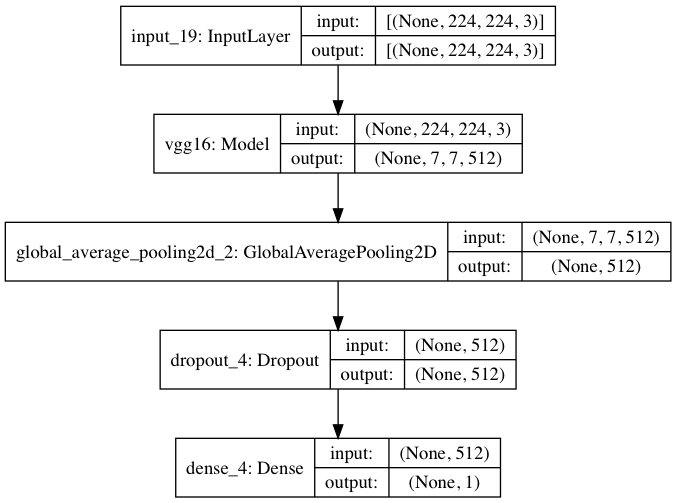

In [103]:
# Model
input_shape = (IMAGE_SIZE2, IMAGE_SIZE2, 3)
inputs = Input(input_shape)
#x = Reshape((224, 224, 3), input_shape=input_shape)(inputs)

vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))(inputs) 
outputs = GlobalAveragePooling2D()(vgg16)
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

plot_model(model,
           to_file=MODEL_PLOT_FILE,
           show_shapes=True,
           show_layer_names=True)

In [104]:
#  Training
history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[#PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=True,
                                                   separator=';')
                              ])

Epoch 1/10
87/88 [============================>.] - ETA: 8s - loss: 0.6943 - accuracy: 0.5590 
Epoch 00001: val_accuracy improved from -inf to 0.67027, saving model to model/model_vgg16_1000.h5
88/88 [==============================] - 758s 9s/step - loss: 0.6940 - accuracy: 0.5618 - val_loss: 0.6433 - val_accuracy: 0.6703
Epoch 2/10
87/88 [============================>.] - ETA: 11s - loss: 0.6518 - accuracy: 0.5926
Epoch 00002: val_accuracy did not improve from 0.67027
88/88 [==============================] - 1060s 12s/step - loss: 0.6530 - accuracy: 0.5915 - val_loss: 0.6484 - val_accuracy: 0.6378
Epoch 3/10
87/88 [============================>.] - ETA: 9s - loss: 0.6308 - accuracy: 0.6296 
Epoch 00003: val_accuracy improved from 0.67027 to 0.68649, saving model to model/model_vgg16_1000.h5
88/88 [==============================] - 896s 10s/step - loss: 0.6301 - accuracy: 0.6304 - val_loss: 0.5842 - val_accuracy: 0.6865
Epoch 4/10
87/88 [============================>.] - ETA: 9s - loss

In [105]:
history.history

{'loss': [0.6863397571260378,
  0.6527450753704088,
  0.6259149979944906,
  0.6813454527740348,
  0.6154614369847409,
  0.5839006655276231,
  0.6087541706024646,
  0.5415110697189784,
  0.5126429492398857,
  0.49095667155301814],
 'accuracy': [0.5617849,
  0.5915332,
  0.6304348,
  0.6006865,
  0.6464531,
  0.7185355,
  0.6636156,
  0.75743705,
  0.76086956,
  0.7814645],
 'val_loss': [0.6432765847758243,
  0.6484378105715701,
  0.5841889899027976,
  0.6641535257038317,
  0.6405988021900779,
  0.5273430135689283,
  0.5912356823682785,
  0.5258498411429556,
  0.5022207529921281,
  0.6043862739675924],
 'val_accuracy': [0.67027026,
  0.6378378,
  0.6864865,
  0.5027027,
  0.6756757,
  0.772973,
  0.73513514,
  0.75135136,
  0.77837837,
  0.72432435]}

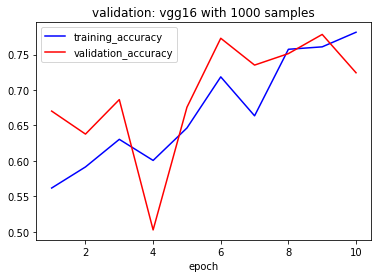

In [107]:
# Training plots
common_title = model_type + ' with ' + str(no_of_images) + ' samples'
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training: ' + common_title)
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation: ' + common_title)
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

19/19 [==============================] - 31s 2s/step


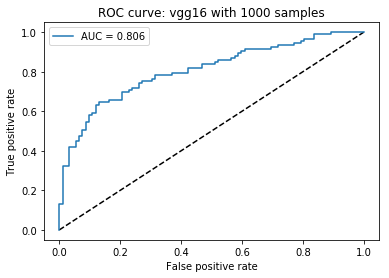

In [108]:
# ROC testing plot
#model.load_weights(MODEL_FILE)
predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: ' + common_title)
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()